In [6]:
spreadsheet = './data/GSE135893_HCAD15.xlsx'

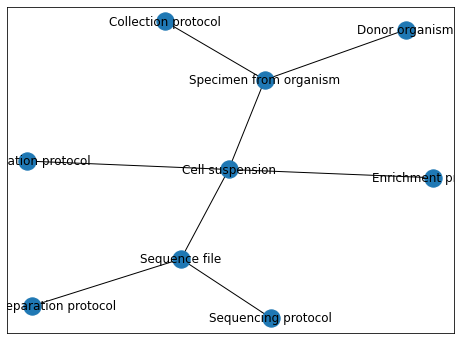

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.Graph()
G.add_node('Sequence file')

G.add_node('Sequencing protocol')
G.add_edge('Sequence file', 'Sequencing protocol', 
           keys=dict(left_on='SEQUENCING PROTOCOL ID (Required)',right_on='SEQUENCING PROTOCOL ID (Required)'))

G.add_node('Library preparation protocol')
G.add_edge('Sequence file','Library preparation protocol')

G.add_node('Cell suspension')
G.add_edge('Sequence file', 'Cell suspension')

G.add_node('Enrichment protocol')
G.add_edge('Cell suspension', 'Enrichment protocol')

G.add_node('Specimen from organism')
G.add_edge('Cell suspension', 'Specimen from organism')

G.add_node('Collection protocol')
G.add_edge('Specimen from organism', 'Collection protocol')

G.add_node('Donor organism')
G.add_edge('Specimen from organism', 'Donor organism')

G.add_node('Enrichment protocol')
G.add_edge('Cell suspension', 'Enrichment protocol')

G.add_node('Dissociation protocol')
G.add_edge('Cell suspension', 'Dissociation protocol')

fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(G, ax=ax)

In [8]:
# TODO: skip unnecessary lines
# TODO: natural language column names vs 
# TODO: render graph

def join_worksheet(acc, sheet_name, left_on, right_on):
    print('joining sheet {}'.format(sheet_name))
    df = pd.read_excel(spreadsheet, sheet_name)
    return acc.merge(df, left_on=left_on, right_on=right_on)

In [9]:
import pandas as pd
from collections import namedtuple

Link = namedtuple("Link", 'source target source_field target_field')

sequence_file = pd.read_excel(spreadsheet, 'Sequence file')
# PROCESS ID (Required)

acc = sequence_file
acc = join_worksheet(acc, sheet_name='Sequencing protocol', left_on='SEQUENCING PROTOCOL ID (Required)', right_on='SEQUENCING PROTOCOL ID (Required)')
acc = join_worksheet(acc, sheet_name='Library preparation protocol', left_on='LIBRARY PREPARATION PROTOCOL ID (Required)',right_on='LIBRARY PREPARATION PROTOCOL ID (Required)')
acc = join_worksheet(acc, sheet_name='Cell suspension', left_on='INPUT CELL SUSPENSION ID (Required)',right_on='CELL SUSPENSION ID (Required)')
acc = join_worksheet(acc, sheet_name='Specimen from organism', left_on='INPUT SPECIMEN FROM ORGANISM ID (Required)',right_on='SPECIMEN FROM ORGANISM ID (Required)')
acc = join_worksheet(acc, sheet_name='Donor organism', left_on='INPUT DONOR ORGANISM ID (Required)',right_on='DONOR ORGANISM ID (Required)')
acc = join_worksheet(acc, sheet_name='Dissociation protocol', left_on='DISSOCIATION PROTOCOL ID (Required)',right_on='DISSOCIATION PROTOCOL ID (Required)')
acc = join_worksheet(acc, sheet_name='Enrichment protocol', left_on='ENRICHMENT PROTOCOL ID (Required)',right_on='ENRICHMENT PROTOCOL ID (Required)')
acc = join_worksheet(acc, sheet_name='Collection protocol', left_on='COLLECTION PROTOCOL ID (Required)',right_on='COLLECTION PROTOCOL ID (Required)')


joining sheet Sequencing protocol
joining sheet Library preparation protocol
joining sheet Cell suspension
joining sheet Specimen from organism
joining sheet Donor organism
joining sheet Dissociation protocol
joining sheet Enrichment protocol
joining sheet Collection protocol


,FILE NAME (Required),FILE FORMAT (Required),CONTENT DESCRIPTION,CONTENT DESCRIPTION ONTOLOGY ID,CONTENT DESCRIPTION ONTOLOGY LABEL ONTOLOGY ID,CHECKSUM,READ INDEX (Required),LANE INDEX,READ LENGTH,INSDC RUN ACCESSION,...,DOCUMENT FILENAME,COLLECTION METHOD (Required),COLLECTION METHOD ONTOLOGY ID,COLLECTION METHOD ONTOLOGY LABEL ONTOLOGY ID,RETAIL NAME_y,CATALOG NUMBER_y,MANUFACTURER_y,BATCH/LOT NUMBER_y,EXPIRY DATE_y,TITER_y
0,The name of the file.,The format of the file.,General description of the contents of the file.,An ontology term identifier in the form prefix...,The preferred label for the ontology term refe...,MD5 checksum of the file.,The sequencing read this file represents.,The lane that this file was sequenced from.,"The length of a sequenced read in this file, i...",An International Nucleotide Sequence Database ...,...,A filename of a PDF document containing the de...,A term that may be associated with a process-r...,An ontology term identifier in the form prefix...,The preferred label for the ontology term refe...,The retail name of the kit/reagent.,The catalog number of the kit/reagent.,The manufacturer of the kit/reagent.,The batch or lot number of the kit/reagent.,The date of expiration for the kit/reagent.,Appropriate titer and volume recommendations f...
1,Include the file extension in the file name. F...,Indicate the full file extension including com...,For example: DNA sequence (raw); Sequence ali...,For example: data:3497; data:0863,For example: DNA sequence (raw); Sequence ali...,For example: e09a986c2e630130b1849d4bf9a94c06,"If a sequencing experiment is single-end, ente...",For example: 1,For example: 51,Enter accession if run has been archived. Acce...,...,For example: my_cool_protocol.pdf,For example: enzymatic dissociation; blood draw,For example: EFO:0009128; EFO:0009121,For example: enzymatic dissociation; blood draw,For example: SureCell WTA 3' Library Prep Kit...,For example: 20014279,For example: Illumina; ThermoFisher Scientific,For example: 10001A,Enter the date in date format: yyyy-mm-dd. Sup...,For example: 3.0x10^7
2,sequence_file.file_core.file_name,sequence_file.file_core.format,sequence_file.file_core.content_description.text,sequence_file.file_core.content_description.on...,sequence_file.file_core.content_description.on...,sequence_file.file_core.checksum,sequence_file.read_index,sequence_file.lane_index,sequence_file.read_length,sequence_file.insdc_run_accessions,...,collection_protocol.protocol_core.document,collection_protocol.method.text,collection_protocol.method.ontology,collection_protocol.method.ontology_label,collection_protocol.reagents.retail_name,collection_protocol.reagents.catalog_number,collection_protocol.reagents.manufacturer,collection_protocol.reagents.lot_number,collection_protocol.reagents.expiry_date,collection_protocol.reagents.kit_titer
3,IPF_VUILD48_1_LU_SCS_C1_X5SCR_F00202_HMWLCBGX7...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,1,NaN,SRR9985297,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
4,IPF_VUILD48_1_LU_SCS_C1_X5SCR_F00202_HMWLCBGX7...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,1,NaN,SRR9985297,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,6,NaN,SRR9985371,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
821,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,7,NaN,SRR9985372,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
822,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,7,NaN,SRR9985372,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
823,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,8,NaN,SRR9985373,...,NaN,biopsy,

In [13]:
from os.path import basename, splitext
acc.to_excel(f'./examples/{splitext(basename(spreadsheet))[0]}_denormalised.xlsx')

In [12]:
acc

,FILE NAME (Required),FILE FORMAT (Required),CONTENT DESCRIPTION,CONTENT DESCRIPTION ONTOLOGY ID,CONTENT DESCRIPTION ONTOLOGY LABEL ONTOLOGY ID,CHECKSUM,READ INDEX (Required),LANE INDEX,READ LENGTH,INSDC RUN ACCESSION,...,DOCUMENT FILENAME,COLLECTION METHOD (Required),COLLECTION METHOD ONTOLOGY ID,COLLECTION METHOD ONTOLOGY LABEL ONTOLOGY ID,RETAIL NAME_y,CATALOG NUMBER_y,MANUFACTURER_y,BATCH/LOT NUMBER_y,EXPIRY DATE_y,TITER_y
0,The name of the file.,The format of the file.,General description of the contents of the file.,An ontology term identifier in the form prefix...,The preferred label for the ontology term refe...,MD5 checksum of the file.,The sequencing read this file represents.,The lane that this file was sequenced from.,"The length of a sequenced read in this file, i...",An International Nucleotide Sequence Database ...,...,A filename of a PDF document containing the de...,A term that may be associated with a process-r...,An ontology term identifier in the form prefix...,The preferred label for the ontology term refe...,The retail name of the kit/reagent.,The catalog number of the kit/reagent.,The manufacturer of the kit/reagent.,The batch or lot number of the kit/reagent.,The date of expiration for the kit/reagent.,Appropriate titer and volume recommendations f...
1,Include the file extension in the file name. F...,Indicate the full file extension including com...,For example: DNA sequence (raw); Sequence ali...,For example: data:3497; data:0863,For example: DNA sequence (raw); Sequence ali...,For example: e09a986c2e630130b1849d4bf9a94c06,"If a sequencing experiment is single-end, ente...",For example: 1,For example: 51,Enter accession if run has been archived. Acce...,...,For example: my_cool_protocol.pdf,For example: enzymatic dissociation; blood draw,For example: EFO:0009128; EFO:0009121,For example: enzymatic dissociation; blood draw,For example: SureCell WTA 3' Library Prep Kit...,For example: 20014279,For example: Illumina; ThermoFisher Scientific,For example: 10001A,Enter the date in date format: yyyy-mm-dd. Sup...,For example: 3.0x10^7
2,sequence_file.file_core.file_name,sequence_file.file_core.format,sequence_file.file_core.content_description.text,sequence_file.file_core.content_description.on...,sequence_file.file_core.content_description.on...,sequence_file.file_core.checksum,sequence_file.read_index,sequence_file.lane_index,sequence_file.read_length,sequence_file.insdc_run_accessions,...,collection_protocol.protocol_core.document,collection_protocol.method.text,collection_protocol.method.ontology,collection_protocol.method.ontology_label,collection_protocol.reagents.retail_name,collection_protocol.reagents.catalog_number,collection_protocol.reagents.manufacturer,collection_protocol.reagents.lot_number,collection_protocol.reagents.expiry_date,collection_protocol.reagents.kit_titer
3,IPF_VUILD48_1_LU_SCS_C1_X5SCR_F00202_HMWLCBGX7...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,1,NaN,SRR9985297,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
4,IPF_VUILD48_1_LU_SCS_C1_X5SCR_F00202_HMWLCBGX7...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,1,NaN,SRR9985297,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,6,NaN,SRR9985371,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
821,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,7,NaN,SRR9985372,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
822,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,7,NaN,SRR9985372,...,NaN,biopsy,EFO:0009120,biopsy,NaN,NaN,NaN,NaN,NaN,NaN
823,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,8,NaN,SRR9985373,...,NaN,biopsy,